In [56]:
# package imports
#basics
import numpy as np
import pandas as pd
import ast

#misc
import gc
import time
import warnings


#viz
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec 
import matplotlib.gridspec as gridspec 

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
import re

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.grid_search import GridSearchCV

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline

In [2]:
#importing business dataset
business=pd.read_csv("yelp_academic_dataset_business.csv")
end_time=time.time()
print("Took",end_time-start_time,"s")

Took 2.258465051651001 s


In [3]:
#take a peak
business.head()

,address,attributes,attributes.AcceptsInsurance,attributes.AgesAllowed,attributes.Alcohol,attributes.Ambience,attributes.BYOB,attributes.BYOBCorkage,attributes.BestNights,attributes.BikeParking,...,hours.Wednesday,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,1314 44 Avenue NE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,11:0-21:0,1,51.091813,-114.031675,Minhas Micro Brewery,NaN,T2E 6L6,24,4.0,AB
1,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN,False,...,NaN,0,35.960734,-114.939821,CK'S BBQ & Catering,NaN,89002,3,4.5,NV
2,1335 rue Beaubien E,NaN,NaN,NaN,beer_and_wine,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,True,...,10:0-22:0,0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC
3,211 W Monroe St,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,33.449999,-112.076979,Geico Insurance,NaN,85003,8,1.5,AZ
4,2005 Alyth Place SE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8:0-17:0,1,51.035591,-114.027366,Action Engine,NaN,T2H 0N5,4,2.0,AB


In [4]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188593 entries, 0 to 188592
Data columns (total 61 columns):
address                                  180970 non-null object
attributes                               0 non-null float64
attributes.AcceptsInsurance              11671 non-null object
attributes.AgesAllowed                   397 non-null object
attributes.Alcohol                       47892 non-null object
attributes.Ambience                      47577 non-null object
attributes.BYOB                          911 non-null object
attributes.BYOBCorkage                   1409 non-null object
attributes.BestNights                    6844 non-null object
attributes.BikeParking                   84891 non-null object
attributes.BusinessAcceptsBitcoin        12674 non-null object
attributes.BusinessAcceptsCreditCards    140391 non-null object
attributes.BusinessParking               103424 non-null object
attributes.ByAppointmentOnly             45423 non-null object
attributes.Ca

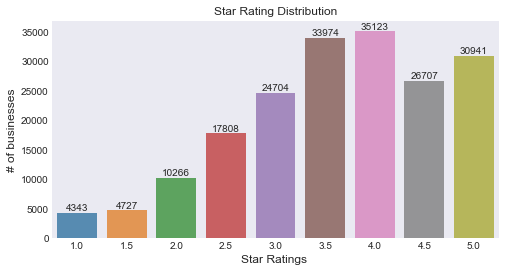

In [5]:
#Get the distribution of the ratings
x=business['stars'].value_counts()
x=x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

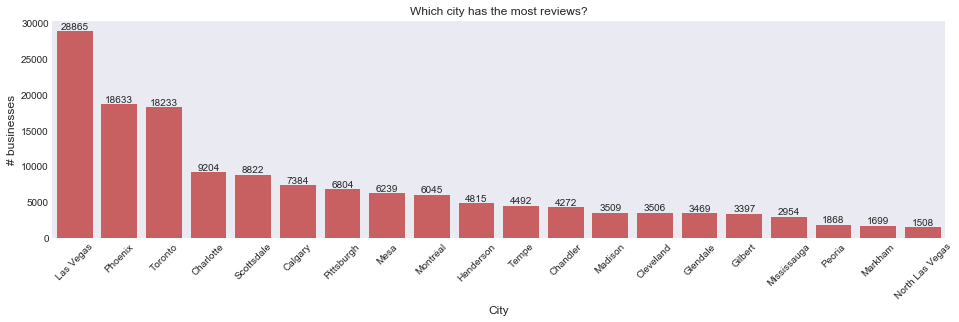

In [6]:
#Get the distribution of the citys
x=business['city'].value_counts()
x=x.sort_values(ascending=False)
x=x.iloc[0:20]
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[3])
plt.title("Which city has the most reviews?")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('City', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()


In [7]:
type(business['categories'])

pandas.core.series.Series

In [8]:
print(business['categories'].head())

0    Tours, Breweries, Pizza, Restaurants, Food, Ho...
1    Chicken Wings, Burgers, Caterers, Street Vendo...
2    Breakfast & Brunch, Restaurants, French, Sandw...
3                        Insurance, Financial Services
4    Home & Garden, Nurseries & Gardening, Shopping...
Name: categories, dtype: object


In [9]:
# What are the popular business categories?
strinfo = re.compile(' ')
business_cat= business['categories'].str.cat(sep = ',')
business_cats = strinfo.sub('', business_cat)
#print(business_cats)
cats=pd.DataFrame(business_cats.split(','),columns=['category'])
print(cats.head())
x=cats.category.value_counts()
print(x.head(20))
print("There are ",len(x)," different types/categories of Businesses in Yelp!")
#prep for chart
x=x.sort_values(ascending=False)
x=x.iloc[0:20]

      category
0        Tours
1    Breweries
2        Pizza
3  Restaurants
4         Food
Restaurants               57173
Shopping                  30231
Food                      27118
Beauty&Spas               18967
HomeServices              18634
Health&Medical            16157
LocalServices             12906
Automotive                12656
Nightlife                 12438
Bars                      10853
EventPlanning&Services     9774
ActiveLife                 9119
Fashion                    7406
Coffee&Tea                 6936
Sandwiches                 6912
HairSalons                 6825
FastFood                   6812
American(Traditional)      6659
Pizza                      6603
Home&Garden                6020
Name: category, dtype: int64
There are  1305  different types/categories of Businesses in Yelp!


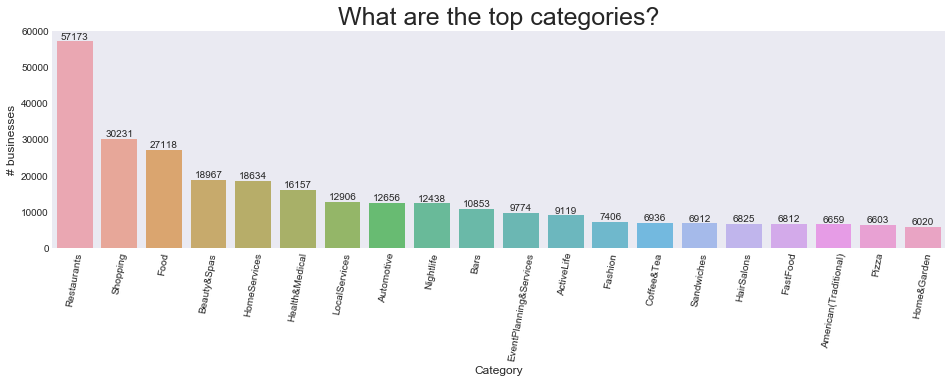

In [10]:
#chart
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)#,color=color[5])
plt.title("What are the top categories?",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()


In [11]:
business_NLasVeg = business[business['city']=='North Las Vegas']
print(business_NLasVeg.head())
print(business_NLasVeg.info())

                           address  attributes attributes.AcceptsInsurance  \
105           2450 Losee Rd, Ste E         NaN                         NaN   
165                  6462 Losee Rd         NaN                         NaN   
268                  3910 W Ann Rd         NaN                        True   
270  5135 Camino Al Norte, Ste 250         NaN                         NaN   
272                4728 W Craig Rd         NaN                         NaN   

    attributes.AgesAllowed attributes.Alcohol attributes.Ambience  \
105                    NaN                NaN                 NaN   
165                    NaN                NaN                 NaN   
268                    NaN                NaN                 NaN   
270                    NaN                NaN                 NaN   
272                    NaN                NaN                 NaN   

    attributes.BYOB attributes.BYOBCorkage attributes.BestNights  \
105             NaN                    NaN      

In [12]:
x=business['city'].value_counts()
print(x.head(20))

Las Vegas          28865
Phoenix            18633
Toronto            18233
Charlotte           9204
Scottsdale          8822
Calgary             7384
Pittsburgh          6804
Mesa                6239
Montréal            6045
Henderson           4815
Tempe               4492
Chandler            4272
Madison             3509
Cleveland           3506
Glendale            3469
Gilbert             3397
Mississauga         2954
Peoria              1868
Markham             1699
North Las Vegas     1508
Name: city, dtype: int64


In [13]:
#change all the nan value into 0
business_NLasVeg = business_NLasVeg.fillna(0).apply(pd.to_numeric, errors = 'ignore')
print(business_NLasVeg.head())
print(business_NLasVeg['attributes.Ambience'].head())

                           address  attributes  attributes.AcceptsInsurance  \
105           2450 Losee Rd, Ste E         0.0                            0   
165                  6462 Losee Rd         0.0                            0   
268                  3910 W Ann Rd         0.0                            1   
270  5135 Camino Al Norte, Ste 250         0.0                            0   
272                4728 W Craig Rd         0.0                            0   

    attributes.AgesAllowed attributes.Alcohol attributes.Ambience  \
105                      0                  0                   0   
165                      0                  0                   0   
268                      0                  0                   0   
270                      0                  0                   0   
272                      0                  0                   0   

     attributes.BYOB attributes.BYOBCorkage attributes.BestNights  \
105                0                     

In [14]:
# check that all nulls are removed
business_NLasVeg.isnull().sum().sum()

0

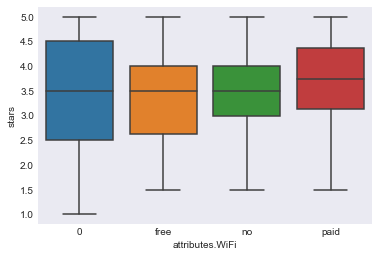

In [15]:
sns.boxplot(x='attributes.WiFi', y='stars', data=business_NLasVeg);

In [16]:
print(business_NLasVeg['categories'].head())

105    Appliances & Repair, IT Services & Computer Re...
165    Doctors, Eyebrow Services, Tattoo Removal, Bea...
268        Dentists, Health & Medical, General Dentistry
270              Movers, Packing Services, Home Services
272    Coffee & Tea, Automotive, Convenience Stores, ...
Name: categories, dtype: object


In [17]:
business_NLasVeg.columns

Index(['address', 'attributes', 'attributes.AcceptsInsurance',
       'attributes.AgesAllowed', 'attributes.Alcohol', 'attributes.Ambience',
       'attributes.BYOB', 'attributes.BYOBCorkage', 'attributes.BestNights',
       'attributes.BikeParking', 'attributes.BusinessAcceptsBitcoin',
       'attributes.BusinessAcceptsCreditCards', 'attributes.BusinessParking',
       'attributes.ByAppointmentOnly', 'attributes.Caters',
       'attributes.CoatCheck', 'attributes.Corkage',
       'attributes.DietaryRestrictions', 'attributes.DogsAllowed',
       'attributes.DriveThru', 'attributes.GoodForDancing',
       'attributes.GoodForKids', 'attributes.GoodForMeal',
       'attributes.HairSpecializesIn', 'attributes.HappyHour',
       'attributes.HasTV', 'attributes.Music', 'attributes.NoiseLevel',
       'attributes.Open24Hours', 'attributes.OutdoorSeating',
       'attributes.RestaurantsAttire', 'attributes.RestaurantsCounterService',
       'attributes.RestaurantsDelivery', 'attributes.Restau

In [18]:
business_NLasVeg["attributes.RestaurantsAttire"].head(10)
#type(business_NLasVeg["review_count"])

105          0
165          0
268          0
270          0
272          0
471          0
560          0
902          0
1060    casual
1068    casual
Name: attributes.RestaurantsAttire, dtype: object

In [19]:
#split categories columns into sub category column
business_NLasVeg['categories_clean'] = list(map(lambda x: ''.join(x.split()),business_NLasVeg['categories'].astype(str)))
#print(business_NLasVeg['categories_clean'])
categories_df = business_NLasVeg.categories_clean.str.get_dummies(sep=',')

business_NLasVeg = business_NLasVeg.merge(categories_df, left_index=True, right_index=True)
print(business_NLasVeg.info())
#print(business_NLasVeg.head())
print(categories_df.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1508 entries, 105 to 188561
Columns: 649 entries, address to Yoga
dtypes: float64(6), int64(615), object(28)
memory usage: 7.5+ MB
None
Index(['0', 'ATVRentals/Tours', 'Accessories', 'Accountants', 'ActiveLife',
       'AdultEducation', 'AdultEntertainment', 'AerialTours',
       'AirDuctCleaning', 'Airports',
       ...
       'Wigs', 'WildlifeControl', 'WindowWashing', 'WindowsInstallation',
       'WindshieldInstallation&Repair', 'Wine&Spirits', 'WineBars',
       'Women'sClothing', 'Wraps', 'Yoga'],
      dtype='object', length=587)


In [20]:
select_df = business_NLasVeg[business_NLasVeg['Restaurants'] == 1]
print(categories_df['Restaurants'].value_counts())
#print(select_df.head())

select_df = select_df.drop(columns = ['attributes'])
select_df.iloc[:, 40:60].head(20)
#print(select_df.info())

0    1173
1     335
Name: Restaurants, dtype: int64


,business_id,categories,city,hours,hours.Friday,hours.Monday,hours.Saturday,hours.Sunday,hours.Thursday,hours.Tuesday,hours.Wednesday,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
1060,ywF14Amq9SLX5o8Qnx3hgA,"Restaurants, Mexican",North Las Vegas,0.0,7:0-20:0,7:0-16:0,7:0-20:0,7:0-20:0,7:0-16:0,7:0-16:0,7:0-16:0,1,36.196344,-115.105675,El Menudazo,0,89030,77,4.0,NV
1068,4MGlJYAiP5RYHzyQozAeAA,"Irish, Sandwiches, Restaurants, Breakfast & Br...",North Las Vegas,0.0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,1,36.261869,-115.184139,Sean Patricks,0,89031,56,3.0,NV
3172,2qIZlW8YSLL8a7I6KkJdHQ,"Mexican, Restaurants",North Las Vegas,0.0,9:0-21:0,9:0-21:0,8:0-0:0,8:0-21:0,9:0-21:0,9:0-21:0,9:0-21:0,0,36.276771,-115.114974,Lina's Mexican Restaurant,0,89086,38,4.0,NV
3390,NQoGxONQIBEJR2iXL-xaQQ,"Restaurants, Pizza",North Las Vegas,0.0,10:0-0:0,10:0-23:0,10:0-0:0,10:0-23:0,10:0-23:0,10:0-23:0,10:0-23:0,1,36.261998,-115.206747,Marco's Pizza,Northwest,89031,38,3.5,NV
5556,Yqg9Muttvbm9s2r-HZY18Q,"Salad, Vegetarian, Sandwiches, Restaurants",North Las Vegas,0.0,10:0-23:0,10:0-22:0,10:0-23:0,10:0-22:0,10:0-22:0,10:0-22:0,10:0-22:0,1,36.241020,-115.096742,Capriotti's Sandwich Shop,0,89030,50,3.5,NV
6350,E6DmUAHfSRCEakvknot-zA,"Seafood, Mexican, Restaurants",North Las Vegas,0.0,0,0,0,0,0,0,0,1,36.204544,-115.117071,Las Islitas Mariscos,0,89030,269,3.5,NV
7138,P8wBSzIVgg-hw9XZ3LWphg,"Restaurants, Mexican",North Las Vegas,0.0,10:0-22:0,10:0-22:0,10:0-22:0,10:0-22:0,10:0-22:0,10:0-22:0,10:0-22:0,1,36.196091,-115.112804,Las Islas Marias,0,89030,9,3.0,NV
7934,FoPkCFoyW1b_S8jLsKjcnQ,"Restaurants, Mexican",North Las Vegas,0.0,9:0-16:0,0,9:0-16:0,9:0-16:0,0,0,0,1,36.211229,-115.102190,Tacos Tijuana,0,89030,11,4.5,NV
9960,swRC2ipDh0nRJZIjyXrU0w,"Restaurants, American (Traditional)",North Las Vegas,0.0,10:0-15:0,10:0-15:0,10:0-15:0,0,10:0-15:0,10:0-15:0,10:0-15:0,0,36.220394,-115.124792,Jake's Filling Station,0,89030,24,5.0,NV
10578,zRSUXYmoPraF1YSWG59gFQ,"American (Traditional), Restaurants, Pubs, Nig...",North Las Vegas,0.0,0,0,0,0,0,0,0,0,36.240816,-115.116347,Winchell's Pub & Grill,0,89030,9,3.0,NV


In [21]:
print(select_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 1060 to 188560
Columns: 648 entries, address to Yoga
dtypes: float64(5), int64(615), object(28)
memory usage: 1.7+ MB
None


In [22]:
print(select_df.columns)

Index(['address', 'attributes.AcceptsInsurance', 'attributes.AgesAllowed',
       'attributes.Alcohol', 'attributes.Ambience', 'attributes.BYOB',
       'attributes.BYOBCorkage', 'attributes.BestNights',
       'attributes.BikeParking', 'attributes.BusinessAcceptsBitcoin',
       ...
       'Wigs', 'WildlifeControl', 'WindowWashing', 'WindowsInstallation',
       'WindshieldInstallation&Repair', 'Wine&Spirits', 'WineBars',
       'Women'sClothing', 'Wraps', 'Yoga'],
      dtype='object', length=648)


In [23]:
# columns with non-boolean categorical values:
cols_to_split = ['attributes.AgesAllowed', 'attributes.Alcohol', 'attributes.BYOBCorkage', 
                 'attributes.NoiseLevel', 'attributes.RestaurantsAttire', 'attributes.Smoking', 'attributes.WiFi']
new_cat = pd.concat([pd.get_dummies(select_df[col], prefix=col, prefix_sep='_') for col in cols_to_split], axis=1)
# keep all columns (not n-1) because 0's for all of them indicates that the data was missing (useful info)
select_df = pd.concat([select_df, new_cat], axis=1)
select_df.drop(cols_to_split, inplace=True, axis=1)
select_df.head()

,address,attributes.AcceptsInsurance,attributes.Ambience,attributes.BYOB,attributes.BestNights,attributes.BikeParking,attributes.BusinessAcceptsBitcoin,attributes.BusinessAcceptsCreditCards,attributes.BusinessParking,attributes.ByAppointmentOnly,...,attributes.NoiseLevel_very_loud,attributes.RestaurantsAttire_0,attributes.RestaurantsAttire_casual,attributes.Smoking_0,attributes.Smoking_no,attributes.Smoking_yes,attributes.WiFi_0,attributes.WiFi_free,attributes.WiFi_no,attributes.WiFi_paid
1060,3100 E Lake Mead,0,"{'romantic': False, 'intimate': False, 'classy...",0,0,1,0,1,"{'garage': False, 'street': False, 'validated'...",0,...,0,0,1,1,0,0,0,0,1,0
1068,3290 W Ann Rd,0,"{'romantic': False, 'intimate': False, 'classy...",0,"{'monday': False, 'tuesday': False, 'friday': ...",1,0,1,"{'garage': False, 'street': False, 'validated'...",0,...,0,0,1,0,0,1,0,0,1,0
3172,"6412 Losee Rd, Ste 100",0,"{'romantic': False, 'intimate': False, 'classy...",0,0,0,0,1,"{'garage': False, 'street': False, 'validated'...",0,...,0,0,1,1,0,0,0,0,1,0
3390,"4770 W Ann Rd, Ste 6",0,"{'romantic': False, 'intimate': False, 'classy...",0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,1,0,0
5556,3820 E Craig Rd,0,"{'romantic': False, 'intimate': False, 'classy...",0,0,0,0,1,"{'garage': False, 'street': False, 'validated'...",0,...,0,0,1,1,0,0,0,0,1,0


In [24]:
print(select_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 1060 to 188560
Columns: 664 entries, address to attributes.WiFi_paid
dtypes: float64(5), int64(615), object(21), uint8(23)
memory usage: 1.6+ MB
None


In [25]:
#drop columns with non-numeric
select_df = select_df.select_dtypes(exclude=['object'])
print(select_df.columns)

Index(['attributes.AcceptsInsurance', 'attributes.BYOB',
       'attributes.BikeParking', 'attributes.BusinessAcceptsBitcoin',
       'attributes.BusinessAcceptsCreditCards', 'attributes.ByAppointmentOnly',
       'attributes.Caters', 'attributes.CoatCheck', 'attributes.Corkage',
       'attributes.DietaryRestrictions',
       ...
       'attributes.NoiseLevel_very_loud', 'attributes.RestaurantsAttire_0',
       'attributes.RestaurantsAttire_casual', 'attributes.Smoking_0',
       'attributes.Smoking_no', 'attributes.Smoking_yes', 'attributes.WiFi_0',
       'attributes.WiFi_free', 'attributes.WiFi_no', 'attributes.WiFi_paid'],
      dtype='object', length=643)


In [26]:
print(select_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 1060 to 188560
Columns: 643 entries, attributes.AcceptsInsurance to attributes.WiFi_paid
dtypes: float64(5), int64(615), uint8(23)
memory usage: 1.6 MB
None


In [27]:
y = select_df['stars']
X = select_df.drop(columns = ['stars'])

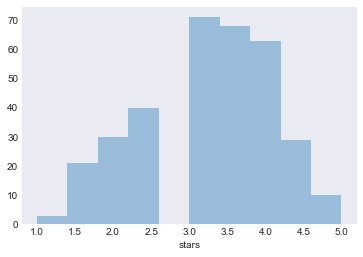

In [28]:
sns.distplot(y, kde=False)

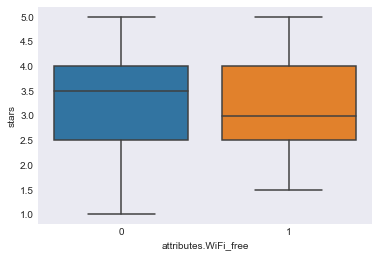

In [29]:
sns.boxplot(x='attributes.WiFi_free', y='stars', data= select_df)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)
print(X_train.shape)
print(X_test.shape)

(234, 642)
(101, 642)


In [31]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [32]:
lasso.fit(X_train, y_train)
y_pred_train = lasso.predict(X_train)
print('Train RMSE:')
print(np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = lasso.predict(X_test)
print('Test RMSE:')
print(np.sqrt(mean_squared_error(y_test, y_pred_test)))

Train RMSE:
0.5800368673917029
Test RMSE:
0.9093493266424525


In [33]:
ENet.fit(X_train, y_train)
y_pred_train = ENet.predict(X_train)
print('Train RMSE:')
print(np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = ENet.predict(X_test)
print('Test RMSE:')
print(np.sqrt(mean_squared_error(y_test, y_pred_test)))

Train RMSE:
0.5794050359223707
Test RMSE:
0.9160403113017858


In [34]:
GBoost.fit(X_train, y_train)
y_pred_train = GBoost.predict(X_train)
print('Train RMSE:')
print(np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = GBoost.predict(X_test)
print('Test RMSE:')
print(np.sqrt(mean_squared_error(y_test, y_pred_test)))

Train RMSE:
0.33384670147881473
Test RMSE:
0.7549843058339633


In [35]:
#use cross-validation instead of train-test split for a better estimation of the RMSE
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
cross_val_scores = cross_val_score(GBoost, X, y, scoring='neg_mean_squared_error', cv=kfold)
print('10-fold RMSEs:')
print([np.sqrt(-x) for x in cross_val_scores])
print('CV RMSE:')
print(np.sqrt(-np.mean(cross_val_scores))) # RMSE is the sqrt of the avg of MSEs
print('Std of CV RMSE:')
print(np.std(cross_val_scores))

10-fold RMSEs:
[0.90019571683844, 0.8035841925436111, 0.7037427164993725, 0.7736793952692828, 0.7656321614970085, 0.8589504166140622, 0.7299556990724387, 0.8239603263209999, 0.949985581295584, 0.9299393136056311]
CV RMSE:
0.827824111713872
Std of CV RMSE:
0.1326967910428538


In [36]:
#parameters tuning for xgboost
def modelfit(alg,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain =xgb.DMatrix(X_train,label=y_train)
        xgtest = xgb.DMatrix(X_test)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds,show_stdv=False)
        alg.set_params(n_estimators=cvresult.shape[0])#cvresult.shape[0] and alg.get_params()['n_estimators'] are same

    #Fit the algorithm on the data
    alg.fit(X_train, y_train,eval_metric='rmse')
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    #Print model report:
    print("Score (Train): %f" % mean_squared_error(y_train.values, dtrain_predictions))
    #Predict on testing data:
    dtest_predictions = alg.predict(X_test)
    print("Score (Test): %f" % mean_squared_error(y_test.values, dtest_predictions))


In [37]:
xgb1 = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 1.1,
                    max_depth= 5,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
modelfit(xgb1)

Score (Train): 0.037059
Score (Test): 0.553299


In [57]:
%%time

#Grid seach for max_depth and min_child_weight tuning

param_test1 = {
    'max_depth':[3,5,7,9],
    'min_child_weight':[1,3,5]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 1.1,
                    max_depth= 5,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27),
                    param_grid = param_test1, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)

CPU times: user 1.23 s, sys: 76.3 ms, total: 1.31 s
Wall time: 13 s


In [39]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.75434, std: 0.14600, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.73818, std: 0.16217, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.73042, std: 0.17354, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.76044, std: 0.12061, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.74657, std: 0.17033, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.73615, std: 0.14945, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.76385, std: 0.14216, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.73575, std: 0.13349, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.72902, std: 0.15856, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.74439, std: 0.09913, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.79265, std: 0.12450, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.72550, std: 0.15679, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 9, 'min_chil

In [58]:
%%time
#try another one
param_test1b = {
    'min_child_weight':[6,8,10,12]
}
gsearch1b = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 1.1,
                    max_depth= 7,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27),
                    param_grid = param_test1b, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1b.fit(X_train,y_train)

CPU times: user 826 ms, sys: 61.5 ms, total: 887 ms
Wall time: 5.1 s


In [59]:
gsearch1b.grid_scores_, gsearch1b.best_params_, gsearch1b.best_score_

([mean: -0.76121, std: 0.13833, params: {'min_child_weight': 6},
  mean: -0.76389, std: 0.14727, params: {'min_child_weight': 8},
  mean: -0.73145, std: 0.14099, params: {'min_child_weight': 10},
  mean: -0.74546, std: 0.13577, params: {'min_child_weight': 12}],
 {'min_child_weight': 10},
 -0.7314454879291914)

In [60]:
%%time
#gamma tuning
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 10,
                    max_depth= 7,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27),
                       param_grid = param_test3, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)

CPU times: user 837 ms, sys: 61.5 ms, total: 899 ms
Wall time: 6.07 s


In [61]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -0.74424, std: 0.12212, params: {'gamma': 0.0},
  mean: -0.73145, std: 0.14099, params: {'gamma': 0.1},
  mean: -0.76799, std: 0.12489, params: {'gamma': 0.2},
  mean: -0.76305, std: 0.12862, params: {'gamma': 0.3},
  mean: -0.72498, std: 0.12775, params: {'gamma': 0.4}],
 {'gamma': 0.4},
 -0.7249840625383424)

In [62]:
%%time
#subsample and colsample_bytree tuning
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.4,
                    min_child_weight= 10,
                    max_depth= 7,
                    subsample= 0.8,
                    colsample_bytree= 0.6,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27),
                       param_grid = param_test4, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)

CPU times: user 983 ms, sys: 82 ms, total: 1.06 s
Wall time: 16.9 s


In [63]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: -0.72264, std: 0.12142, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -0.73863, std: 0.14613, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -0.74325, std: 0.13685, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -0.70946, std: 0.12145, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -0.72185, std: 0.13914, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -0.74061, std: 0.15309, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -0.74498, std: 0.14058, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: -0.73222, std: 0.13209, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: -0.70910, std: 0.12353, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: -0.71814, std: 0.12934, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: -0.72498, std: 0.12775, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: -0.73298, std: 0.12744, params: {'colsample_bytree': 0.8,

In [64]:
%%time
#reg_alpha、reg_lambda rough tuning

param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.4,
                    min_child_weight= 10,
                    max_depth= 7,
                    subsample= 0.8,
                    colsample_bytree= 0.6,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27),
                    param_grid = param_test6, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train,y_train)


CPU times: user 672 ms, sys: 62.3 ms, total: 734 ms
Wall time: 4.8 s


In [65]:
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: -0.74325, std: 0.13685, params: {'reg_alpha': 1e-05},
  mean: -0.73535, std: 0.13829, params: {'reg_alpha': 0.01},
  mean: -0.74764, std: 0.11554, params: {'reg_alpha': 0.1},
  mean: -0.71324, std: 0.15186, params: {'reg_alpha': 1},
  mean: -1.23661, std: 0.19673, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 -0.7132417001396024)

In [66]:
%%time
##reg_alpha、reg_lambda fine tuning
param_test7 = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.4,
                    min_child_weight= 10,
                    max_depth= 7,
                    subsample= 0.8,
                    colsample_bytree= 0.6,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27),
                       param_grid = param_test7, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_train,y_train)

CPU times: user 702 ms, sys: 60.8 ms, total: 763 ms
Wall time: 4.64 s


In [67]:
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: -0.74325, std: 0.13685, params: {'reg_alpha': 0},
  mean: -0.74322, std: 0.13684, params: {'reg_alpha': 0.001},
  mean: -0.75105, std: 0.13057, params: {'reg_alpha': 0.005},
  mean: -0.73535, std: 0.13829, params: {'reg_alpha': 0.01},
  mean: -0.73670, std: 0.13679, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.01},
 -0.735347370058071)

In [68]:
%%time
#reduce learning_rate, increase n_estimators
param_test9 = {
    'n_estimators':[50, 100, 200, 500,1000],
    'learning_rate':[0.001, 0.01, 0.05, 0.1,0.2]
}
gsearch9 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.4,
                    min_child_weight= 10,
                    max_depth= 7,
                    subsample= 0.8,
                    colsample_bytree= 0.6,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    nthread=4,
                    scale_pos_weight=1,
                    reg_alpha=0.01,                           
                    seed=27),
                       param_grid = param_test9, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch9.fit(X_train,y_train)



CPU times: user 2.91 s, sys: 78.8 ms, total: 2.99 s
Wall time: 1min 3s


In [69]:
gsearch9.grid_scores_, gsearch9.best_params_, gsearch9.best_score_

([mean: -7.59732, std: 0.44923, params: {'learning_rate': 0.001, 'n_estimators': 50},
  mean: -6.94856, std: 0.42006, params: {'learning_rate': 0.001, 'n_estimators': 100},
  mean: -5.82811, std: 0.36739, params: {'learning_rate': 0.001, 'n_estimators': 200},
  mean: -3.52629, std: 0.24897, params: {'learning_rate': 0.001, 'n_estimators': 500},
  mean: -1.73238, std: 0.14353, params: {'learning_rate': 0.001, 'n_estimators': 1000},
  mean: -3.50692, std: 0.24124, params: {'learning_rate': 0.01, 'n_estimators': 50},
  mean: -1.72382, std: 0.13514, params: {'learning_rate': 0.01, 'n_estimators': 100},
  mean: -0.79212, std: 0.10785, params: {'learning_rate': 0.01, 'n_estimators': 200},
  mean: -0.66393, std: 0.12769, params: {'learning_rate': 0.01, 'n_estimators': 500},
  mean: -0.70632, std: 0.13441, params: {'learning_rate': 0.01, 'n_estimators': 1000},
  mean: -0.69037, std: 0.11839, params: {'learning_rate': 0.05, 'n_estimators': 50},
  mean: -0.67685, std: 0.13096, params: {'learning

In [52]:
xgb9 = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.4,
                    min_child_weight= 10,
                    max_depth= 7,
                    subsample= 0.8,
                    colsample_bytree= 0.6,
                    tree_method= 'exact',
                    learning_rate=0.01,
                    n_estimators=500,
                    nthread=4,
                    scale_pos_weight=1,
                    reg_alpha=0.05,                           
                    seed=27)

In [53]:
xgb9.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='rmse', gamma=0.4,
       learning_rate=0.01, max_delta_step=0, max_depth=7,
       min_child_weight=10, missing=None, n_estimators=500, n_jobs=1,
       nthread=4, objective='reg:linear', random_state=0, reg_alpha=0.05,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8, tree_method='exact')

In [54]:
sqrt(mean_squared_error(xgb9.predict(X_test),y_test))

0.7442509524551613

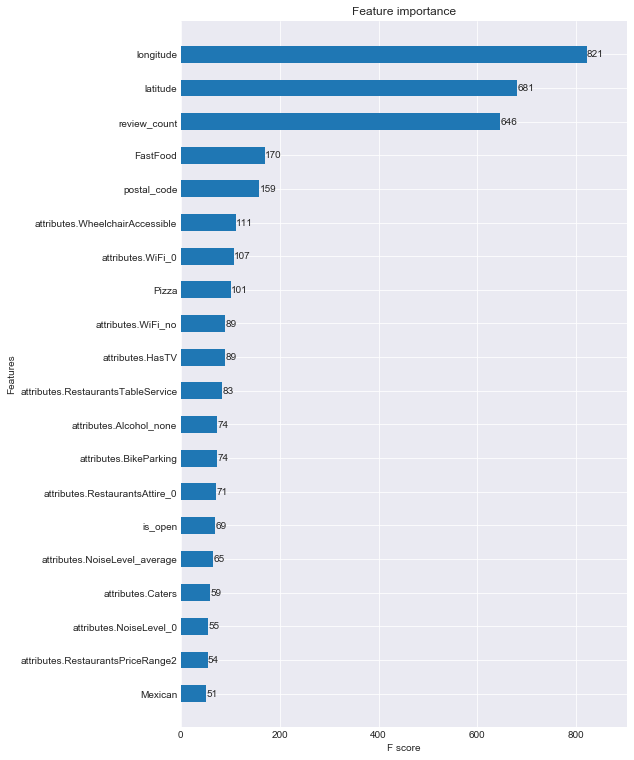

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(xgb9, max_num_features=20, height=0.5, ax=ax)